# Stock Market Prediction Model Using Linear Regression

### **Preface**

**This project aims to develop a Linear Regression model** to predict the stock price of **ITC Limited** using historical data from **01/01/2021 to 09/09/2024**. The model integrates past stock prices from the previous three days and market sentiment indicators based on the **Nifty index**.

**The regression equation is:**

\[ y = b_1 + b_2x_2 + b_3x_3 + b_4x_4 + b_5x_5 + b_6x_6 + b_7x_7 \]

**Where:**
- **y** is the predicted stock price.
- **x2, x3, x4** are prior day prices.
- **x5** and **x6** denote negative and positive market sentiment, respectively.
- **x7** represents the date.

**In addition, this project seeks to mimic aspects of a Markov model** by incorporating historical price trends and market conditions, aiming to capture the state-dependent transitions that influence stock price movements. **The goal is to create a model that not only forecasts stock prices but also reflects the probabilistic nature of price changes influenced by past states.**


This project is designed for the average person who wants to understand the stock price prediction. To make it accessible, the model uses features that are readily available to anyone: the previous day's stock price, the market sentiment , and the current date. These features are chosen as independent variables because they are based on information that is known and available, with no reliance on future data.

In [1]:
import numpy as np                                   # for data manipulation
import pandas as pd 

import matplotlib.pyplot as plt                      # for data visualisation
import seaborn as sns
sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import statsmodels.api as sm
import math

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Read the DATA

In [2]:
data1 = pd.read_csv('ITC Historical Data.csv')
data1.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,06-09-2024,501.70,512.00,512.00,497.15,13.72M,-1.86%
1,05-09-2024,511.20,508.35,511.90,507.05,10.90M,0.96%
2,04-09-2024,506.35,500.00,510.05,499.95,8.41M,-0.60%
3,03-09-2024,509.40,510.05,515.95,507.90,12.02M,-0.13%
4,02-09-2024,510.05,504.00,512.90,503.30,15.89M,1.62%


In [3]:
# drop the columns

data  = data1.drop(columns=['Open','High','Low','Vol.','Change %'])  
data.head()

,Date,Price
0,06-09-2024,501.70
1,05-09-2024,511.20
2,04-09-2024,506.35
3,03-09-2024,509.40
4,02-09-2024,510.05


"We are removing rows corresponding to dates that fall on Saturdays or Sundays, as the market remains closed on these days, at least in India. 😊"

In [4]:
# Create three new variables representing the stock prices from one, two, and three days prior, respectively.


data['Prior day price 1'] = data['Price'].shift(-1,fill_value = 0)
data['Prior day price 2'] = data['Price'].shift(-2,fill_value = 0)
data['Prior day price 3'] = data['Price'].shift(-3,fill_value = 0)
data

,Date,Price,Prior day price 1,Prior day price 2,Prior day price 3
0,06-09-2024,501.70,511.20,506.35,509.40
1,05-09-2024,511.20,506.35,509.40,510.05
2,04-09-2024,506.35,509.40,510.05,501.90
3,03-09-2024,509.40,510.05,501.90,505.10
4,02-09-2024,510.05,501.90,505.10,497.30
...,...,...,...,...,...
908,07-01-2021,202.80,205.40,211.45,213.40
909,06-01-2021,205.40,211.45,213.40,213.85
910,05-01-2021,211.45,213.40,213.85,0.00
911,04-01-2021,213.40,213.85,0.00,0.00


#    We have used the Nifty 50 index.   
The NIFTY 50 is a benchmark Indian stock market index that represents the weighted average of 50 of the largest Indian companies listed on the National Stock Exchange. 

In [5]:
data2 = pd.read_csv('Nifty 50 Historical Data-2.csv')
data2.head()


,Date,Price,Open,High,Low,Vol.,Change %
0,06-09-2024,"24,852.15","25,093.70","25,168.75","24,801.30",311.67M,-1.17%
1,05-09-2024,"25,145.10","25,250.50","25,275.45","25,127.75",222.24M,-0.21%
2,04-09-2024,"25,198.70","25,089.95","25,216.00","25,083.80",253.79M,-0.32%
3,03-09-2024,"25,279.85","25,313.40","25,321.70","25,235.80",212.13M,0.00%
4,02-09-2024,"25,278.70","25,333.60","25,333.65","25,235.50",222.82M,0.17%


"We are removing rows corresponding to dates that fall on Saturdays or Sundays, as the market remains closed on these days, at least in India. 😊"

In [6]:
data2.shape, data.shape

((913, 7), (913, 5))

In [7]:
# Clean 'Change %' column: remove '%' and convert to float
data2['Change %'] = data2['Change %'].str.replace('%', '').astype(float)

In [8]:
# Initialize the new sentiment columns
data['Negative Market Sentiment'] = 0
data['Positive Market Sentiment'] = 0


for index,row in data2.iterrows():
    if row['Change %'] <=  -1:
        data.at[index,'Negative Market Sentiment'] =1
        
    if row['Change %'] >=  1:
        data.at[index,'Positive Market Sentiment'] = 1
        
    

 We have created two new variables: Negative Market Sentiment and Positive Market Sentiment. These variables are set to 0 or 1 based on whether the Change % is less than or equal to -1 for negative sentiment, or greater than or equal to 1 for positive sentiment. We then shift these values by one day to reflect the market sentiment from the previous day.

In [9]:
data['Negative Market Sentiment'] = data['Negative Market Sentiment'].shift(-1,fill_value = 0)
data['Positive Market Sentiment'] = data['Positive Market Sentiment'].shift(-1,fill_value = 0)

In [10]:
data.shape

(913, 7)

Here, we will manually fill in the prior day prices for the last three days for PriorDayPrice1, PriorDayPrice2, and PriorDayPrice3. The NegativeMarketSentiment and PositiveMarketSentiment columns will remain unchanged, as per the available data."

In [11]:
data.iloc[910,4] = 209
data.iloc[911,4] = 211.15
data.iloc[911,3] = 209
data.iloc[912,4] = 211.55
data.iloc[912,3] = 211.15
data.iloc[912,2] = 209

In [12]:
# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

# Extract features from the 'Date' column

data['DaysSince'] = (data['Date'] - pd.Timestamp('2021-01-01')).dt.days

data

,Date,Price,Prior day price 1,Prior day price 2,Prior day price 3,Negative Market Sentiment,Positive Market Sentiment,DaysSince
0,2024-09-06,501.70,511.20,506.35,509.40,0,0,1344
1,2024-09-05,511.20,506.35,509.40,510.05,0,0,1343
2,2024-09-04,506.35,509.40,510.05,501.90,0,0,1342
3,2024-09-03,509.40,510.05,501.90,505.10,0,0,1341
4,2024-09-02,510.05,501.90,505.10,497.30,0,0,1340
...,...,...,...,...,...,...,...,...
908,2021-01-07,202.80,205.40,211.45,213.40,0,0,6
909,2021-01-06,205.40,211.45,213.40,213.85,0,0,5
910,2021-01-05,211.45,213.40,213.85,209.00,0,0,4
911,2021-01-04,213.40,213.85,209.00,211.15,0,0,3


# Understanding the data

In [13]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913 entries, 0 to 912
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       913 non-null    datetime64[ns]
 1   Price                      913 non-null    float64       
 2   Prior day price 1          913 non-null    float64       
 3   Prior day price 2          913 non-null    float64       
 4   Prior day price 3          913 non-null    float64       
 5   Negative Market Sentiment  913 non-null    int64         
 6   Positive Market Sentiment  913 non-null    int64         
 7   DaysSince                  913 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 57.2 KB


In [14]:
data.describe()

,Price,Prior day price 1,Prior day price 2,Prior day price 3,Negative Market Sentiment,Positive Market Sentiment,DaysSince
count,913.000000,913.000000,913.000000,913.000000,913.000000,913.000000,913.000000
mean,333.748981,333.428390,333.099748,332.776857,0.100767,0.112815,672.705367
std,100.151136,100.081375,99.989580,99.905454,0.301185,0.316540,388.362924
min,199.600000,199.600000,199.600000,199.600000,0.000000,0.000000,0.000000
25%,226.000000,225.600000,225.500000,225.450000,0.000000,0.000000,339.000000
50%,333.000000,332.800000,332.600000,332.550000,0.000000,0.000000,672.000000
75%,434.350000,433.750000,433.650000,433.350000,0.000000,0.000000,1008.000000
max,511.200000,511.200000,510.050000,510.050000,1.000000,1.000000,1344.000000


In [15]:
data.isnull().sum()            # checking for null values

Date                         0
Price                        0
Prior day price 1            0
Prior day price 2            0
Prior day price 3            0
Negative Market Sentiment    0
Positive Market Sentiment    0
DaysSince                    0
dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

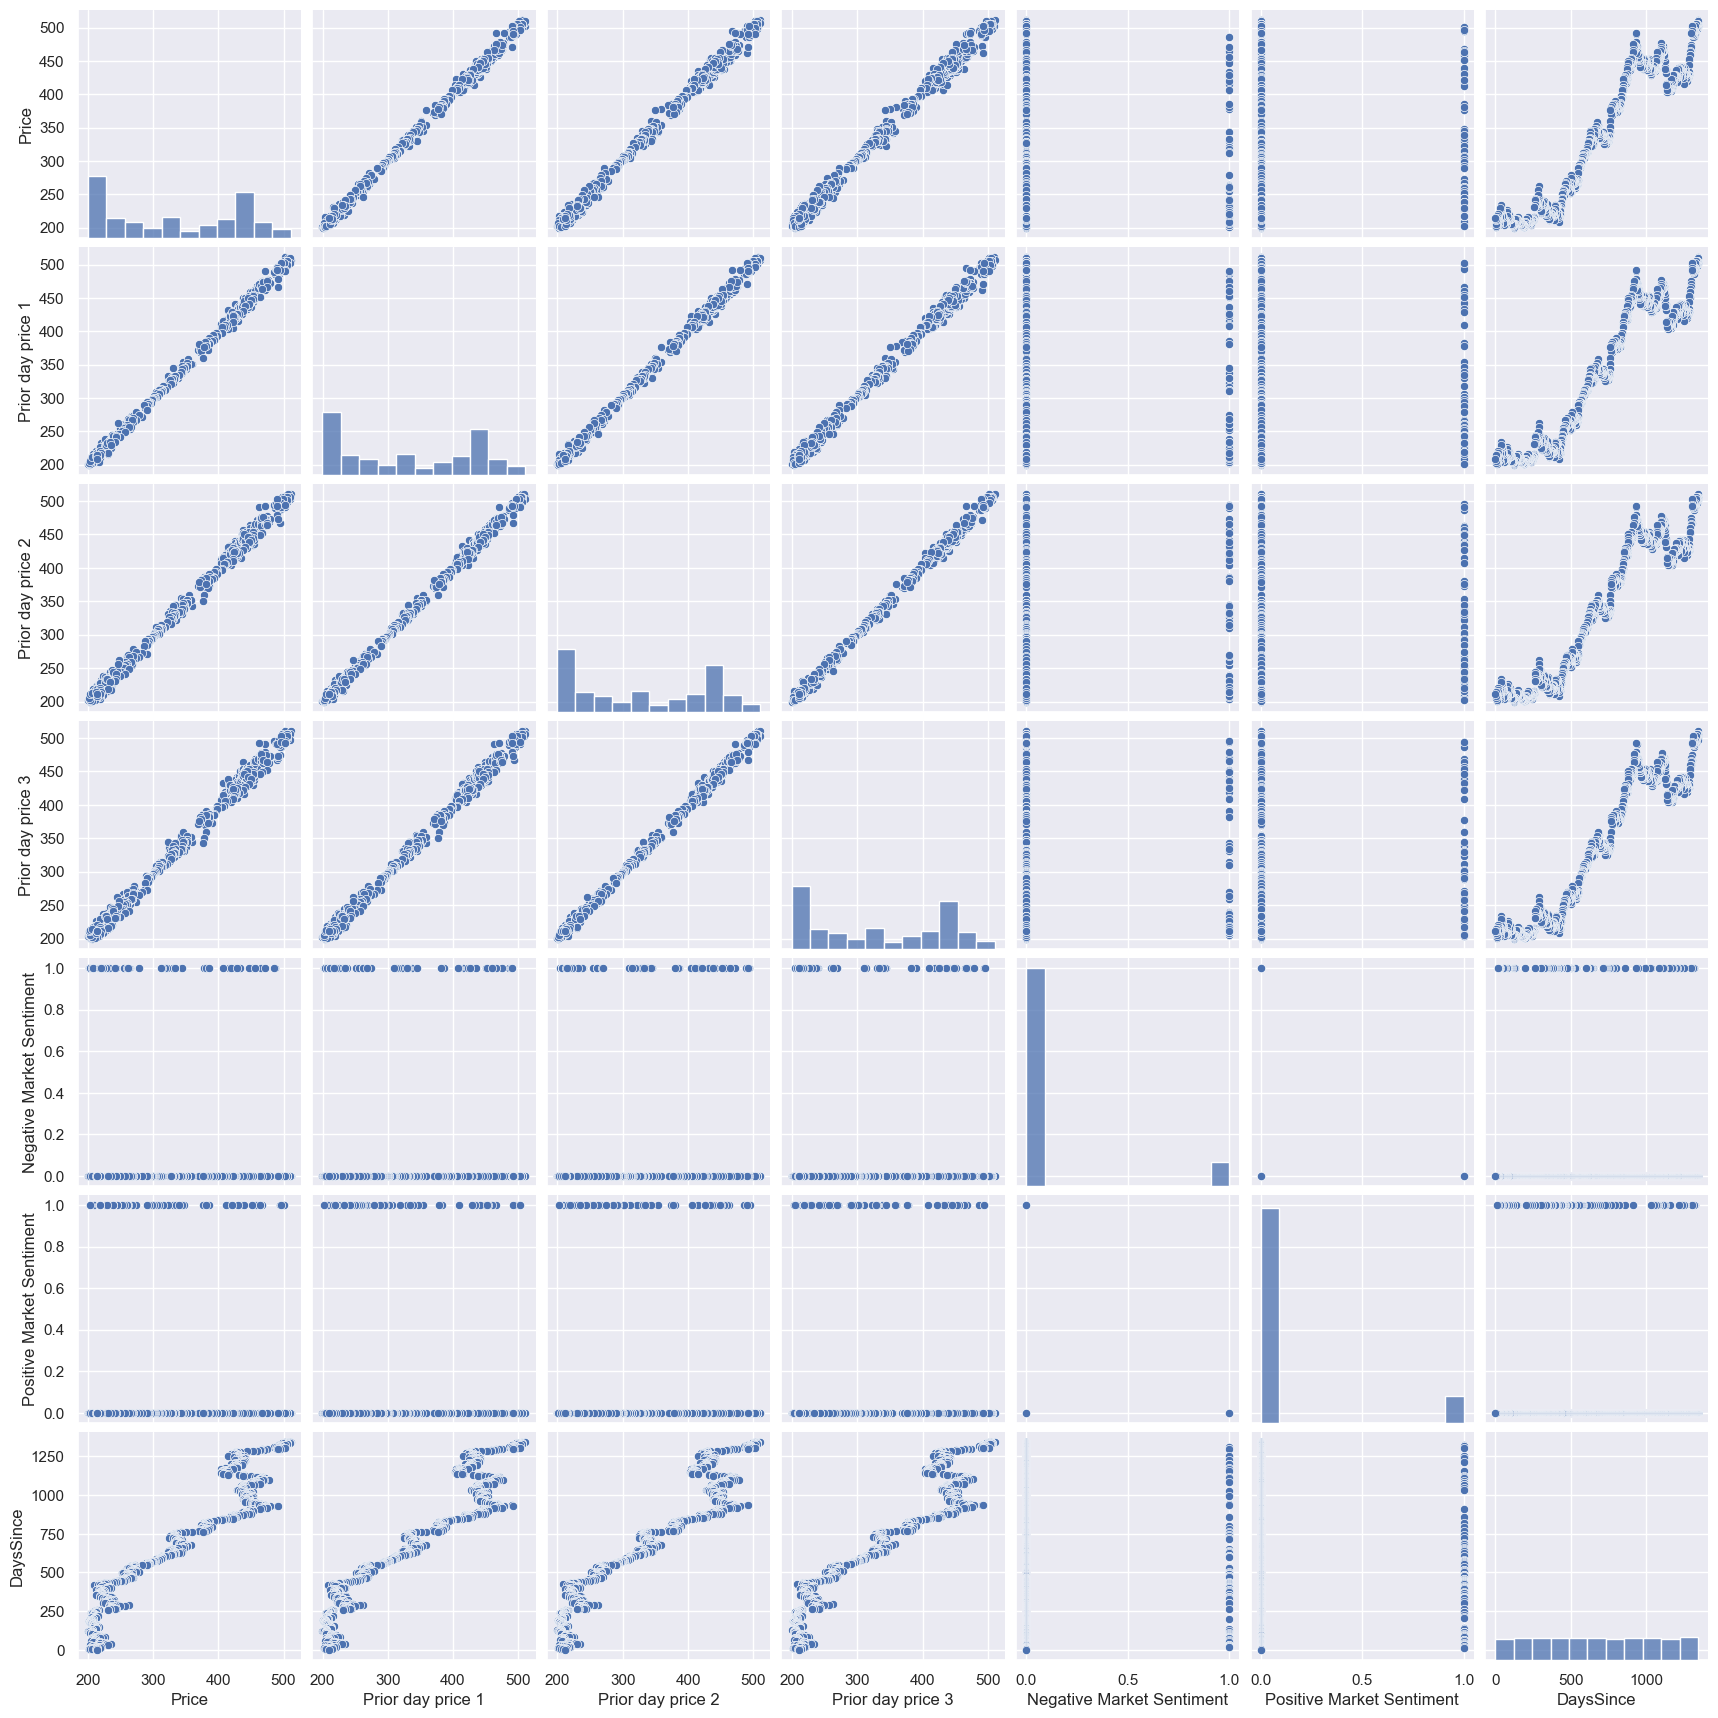

In [16]:
sns.pairplot(data)
plt.show

In [17]:
 #Split the Data
data

,Date,Price,Prior day price 1,Prior day price 2,Prior day price 3,Negative Market Sentiment,Positive Market Sentiment,DaysSince
0,2024-09-06,501.70,511.20,506.35,509.40,0,0,1344
1,2024-09-05,511.20,506.35,509.40,510.05,0,0,1343
2,2024-09-04,506.35,509.40,510.05,501.90,0,0,1342
3,2024-09-03,509.40,510.05,501.90,505.10,0,0,1341
4,2024-09-02,510.05,501.90,505.10,497.30,0,0,1340
...,...,...,...,...,...,...,...,...
908,2021-01-07,202.80,205.40,211.45,213.40,0,0,6
909,2021-01-06,205.40,211.45,213.40,213.85,0,0,5
910,2021-01-05,211.45,213.40,213.85,209.00,0,0,4
911,2021-01-04,213.40,213.85,209.00,211.15,0,0,3


In [18]:
X  = data[["Prior day price 1","Prior day price 2","Prior day price 3","Negative Market Sentiment","Positive Market Sentiment","DaysSince"]]  #input
y = data[["Price"]]

In [22]:
X_train , X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [23]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_1 = scaler.fit_transform(y)
X_1 =scaler.fit_transform(X)




                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          7.952e+04
Date:                Mon, 09 Sep 2024   Prob (F-statistic):                        0.00
Time:                        10:23:14   Log-Likelihood:                          1565.5
No. Observations:                 913   AIC:                                     -3119.
Df Residuals:                     907   BIC:                                     -3090.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

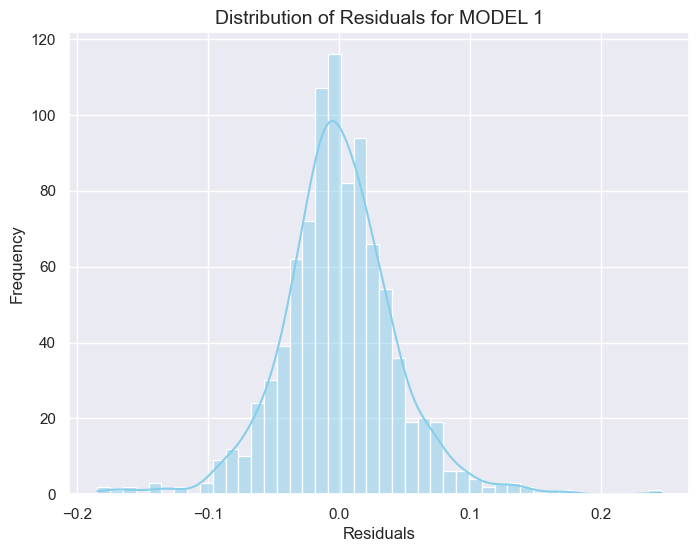

In [24]:
lm1=sm.OLS(y_1,X_1)
result1 = lm1.fit()


# Print the summary of the regression results
print(result1.summary())

residuals = result1.resid


# Plotting the distribution of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='skyblue')
plt.title('Distribution of Residuals for MODEL 1', fontsize=14)
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

In [25]:
lm2 = LinearRegression()
lm2.fit(X_train,y_train)

LinearRegression()

In [26]:
lm2.coef_

array([[ 8.92788315e+01,  8.83701786e+00,  3.71215473e-01,
         2.54875895e-02, -6.05190488e-02,  1.20345844e+00]])

In [27]:
lm2.score(X_train,y_train)

0.9980708988652142

In [28]:
prediction = lm2.predict(X_test)

In [29]:
#metrics to find accuracy of continous variables
print('Mean Abs value:' ,metrics.mean_absolute_error(y_test,prediction))
print('Mean squared value:',metrics.mean_squared_error(y_test,prediction))
print('root mean squared error value:',math.sqrt(metrics.mean_squared_error(y_test,prediction)))

Mean Abs value: 3.134080561842757
Mean squared value: 18.856621288243367
root mean squared error value: 4.342421132069455


In [30]:
##Transformback to original form
#X_1=scaler.inverse_transform(X_1)

# Predict on the test set
data['PredictedPrice'] = lm2.predict(X_1)


Locator attempting to generate 1479 ticks ([18561.0, ..., 20039.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1479 ticks ([18561.0, ..., 20039.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1479 ticks ([18561.0, ..., 20039.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1479 ticks ([18561.0, ..., 20039.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1479 ticks ([18561.0, ..., 20039.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1479 ticks ([18561.0, ..., 20039.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1479 ticks ([18561.0, ..., 20039.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1479 ticks ([18561.0, ..., 20039.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1479 ticks ([18561.0, ..., 20039.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to genera

Locator attempting to generate 1479 ticks ([18561.0, ..., 20039.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1479 ticks ([18561.0, ..., 20039.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1479 ticks ([18561.0, ..., 20039.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1479 ticks ([18561.0, ..., 20039.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1479 ticks ([18561.0, ..., 20039.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1479 ticks ([18561.0, ..., 20039.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1479 ticks ([18561.0, ..., 20039.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1479 ticks ([18561.0, ..., 20039.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1479 ticks ([18561.0, ..., 20039.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to genera

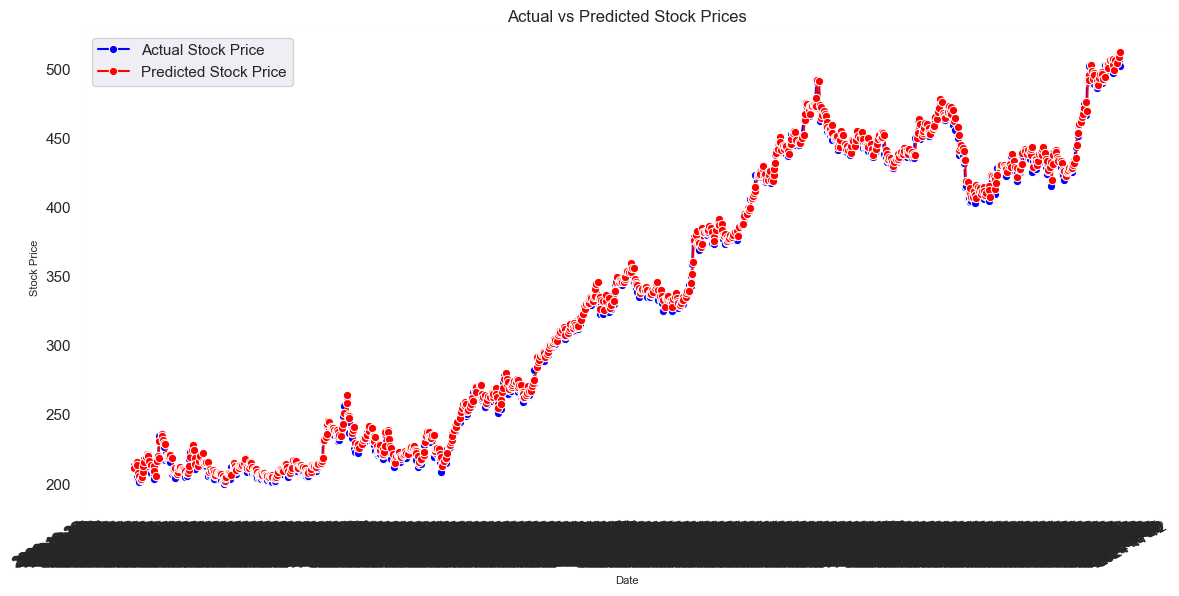

In [31]:


# Plotting
plt.figure(figsize=(14, 7))

# Plot actual stock prices
sns.lineplot(x='Date', y='Price', data=data, marker='o', label='Actual Stock Price', color='blue')

# Plot predicted stock prices
sns.lineplot(x='Date', y='PredictedPrice', data=data, marker='o', label='Predicted Stock Price', color='red')

# Adding labels and title
plt.title('Actual vs Predicted Stock Prices', fontsize=12)
plt.xlabel('Date', fontsize=8)
plt.ylabel('Stock Price', fontsize=8)

# Formatting the x-axis to show dates correctly
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=1))
plt.gcf().autofmt_xdate()  # Rotate date labels

# Adding legend
plt.legend()

# Adding grid
plt.grid(True)

# Display the plot
plt.show()


In [32]:
data

,Date,Price,Prior day price 1,Prior day price 2,Prior day price 3,Negative Market Sentiment,Positive Market Sentiment,DaysSince,PredictedPrice
0,2024-09-06,501.70,511.20,506.35,509.40,0,0,1344,512.420494
1,2024-09-05,511.20,506.35,509.40,510.05,0,0,1343,508.360641
2,2024-09-04,506.35,509.40,510.05,501.90,0,0,1342,511.107001
3,2024-09-03,509.40,510.05,501.90,505.10,0,0,1341,510.975269
4,2024-09-02,510.05,501.90,505.10,497.30,0,0,1340,503.951846
...,...,...,...,...,...,...,...,...,...
908,2021-01-07,202.80,205.40,211.45,213.40,0,0,6,208.152025
909,2021-01-06,205.40,211.45,213.40,213.85,0,0,5,213.722968
910,2021-01-05,211.45,213.40,213.85,209.00,0,0,4,215.482104
911,2021-01-04,213.40,213.85,209.00,211.15,0,0,3,215.459770


In [79]:
# Compute correlation matrix
correlation_matrix = data.corr()

# Print correlation between X and y
print("Correlation between X and y:")
print(correlation_matrix['Price'].drop('Price'))



Correlation between X and y:
Prior day price 1            0.999043
Prior day price 2            0.998174
Prior day price 3            0.997308
Negative Market Sentiment   -0.129497
Positive Market Sentiment   -0.133534
DaysSince                    0.951230
PredictedPrice               0.999048
Name: Price, dtype: float64


In [33]:
from sklearn.metrics import r2_score 
r2_score(y_test, prediction)

0.9981505151671165

In [ ]:
# It is clear from the data that a high R² indicates a strong relationship between y and x1, x2, x3. 
#This implies that the independent variables collectively explain a large portion of the variance in y. 